In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from geofastai import *

## Create a dataframe with image paths

In [3]:
city_imgs = AerialCity('atlanta')
df, n_matches = city_imgs.create_df()
df.head()

['all_sat_LLAHTR', 'all_uav_LLAHTR', 'all_uav_xyzHTR', 'match_array_40', 'sat300_image_paths', 'uav_image_paths']


,uav,sat,label,is_valid
0,train/atlanta/uav-small/uav0.png,train/atlanta/sat-small/sat0.png,1,False
1,train/atlanta/uav-small/uav0.png,train/atlanta/sat-small/sat10.png,1,False
2,train/atlanta/uav-small/uav0.png,train/atlanta/sat-small/sat15.png,1,False
3,train/atlanta/uav-small/uav1.png,train/atlanta/sat-small/sat1.png,1,False
4,train/atlanta/uav-small/uav1.png,train/atlanta/sat-small/sat28.png,1,False


In [4]:
mean, std = torch.tensor(imagenet_stats)
# for 3 channels
mean = mean[...,None,None]
std = std  [...,None,None]

## Custom `ImageTupleList` for training dual network

In [5]:
# The primary difference from the tutorial is with how normalization is being done here
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj = (img1,img2)
        self.data = [(img1.data-mean)/std, (img2.data-mean)/std]
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms[0], **kwargs)
        self.img2 = self.img2.apply_tfms(tfms[1], **kwargs)
        self.data = [(self.img1.data-mean)/std, (self.img2.data-mean)/std]
        return self    
    def to_one(self): return Image(mean+torch.cat(self.data,2)*std)
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'

In [6]:
class ImageTupleList(ImageList):
    def __init__(self, items, itemsB=None, **kwargs):
        super().__init__(items, **kwargs)
        self.itemsB = itemsB
        self.copy_new.append('itemsB')
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[i]
        return ImageTuple(img1, open_image(fn))
    
    @classmethod
    def from_dfs(cls, df:DataFrame, path='.', cols=0, colsB=1, **kwargs):
        "Create an `ItemList` in `path` from the inputs in the `cols` of `df`."
        t_itemsB = ImageList.from_df(df[df['is_valid']==False], path, colsB).items
        t_res = super().from_df(df[df['is_valid']==False],path,cols, itemsB=t_itemsB, **kwargs)
        v_itemsB = ImageList.from_df(df[df['is_valid']==True],  path, colsB).items
        v_res = super().from_df(df[df['is_valid']==True],path,cols, itemsB=v_itemsB, **kwargs)
        t_res.path = v_res.path = path
        return ItemLists(t_res.path, t_res, v_res)
       
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]*std+mean),Image(t[1]*std+mean))
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

## Create a databunch

In [7]:
target_col = 2
is_valid_col = 3
bs = 32
data = (ImageTupleList.from_dfs(df, path='.', cols=0, colsB=1)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .databunch(bs=bs))

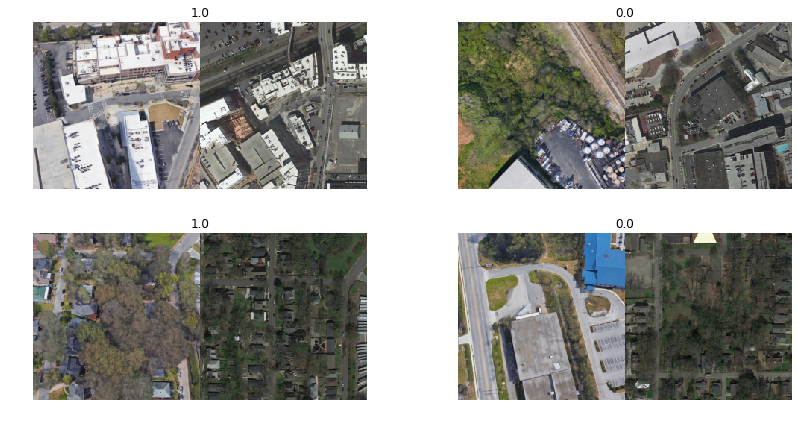

In [8]:
data.show_batch(2, DatasetType.Train) # images before data augmentation

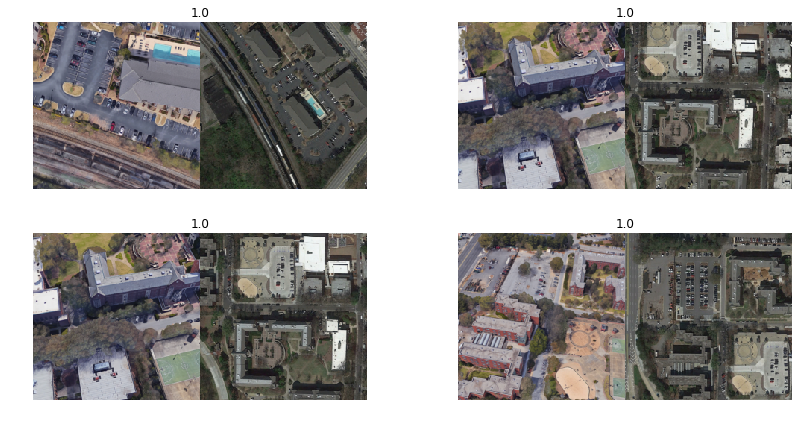

In [9]:
data.show_batch(2, DatasetType.Valid) # images before data augmentation

In [10]:
tfms_uav = get_transforms()
tfms_sat = get_transforms(flip_vert=True)

In [11]:
data.train_ds.tfms = [tfms_uav[0], tfms_uav[0]]

In [12]:
data.valid_ds.tfms = [tfms_uav[1], tfms_uav[1]]

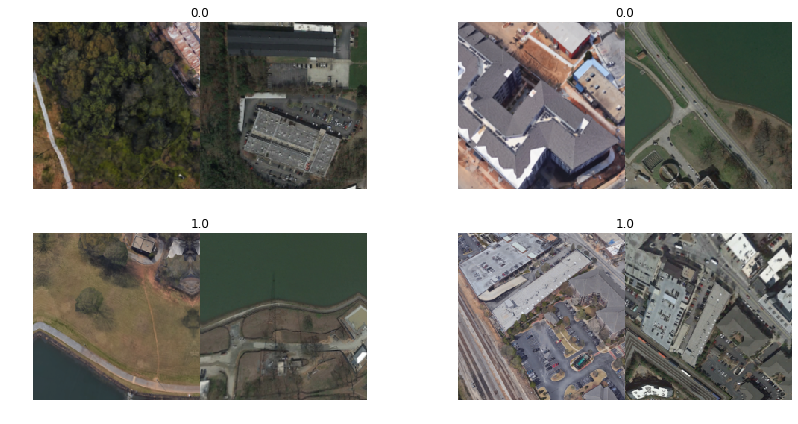

In [13]:
data.show_batch(2, DatasetType.Train)

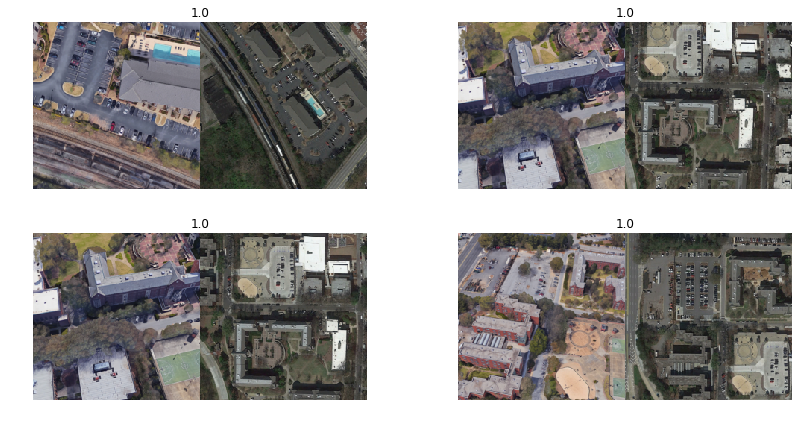

In [14]:
data.show_batch(2, DatasetType.Valid)

In [15]:
data.train_ds.tfms

[[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.9383179520304118, 'col_pct': 0.3910173913372461, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([-0.1458,  0.1808, -0.1128,  0.1644]), 'invert': False}, do_run=False, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={'degrees': 8.122509224277863}, do_run=False, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={'scale': 1.0534334160291638, 'row_pct': 0.16389224029908034, 'col_pct': 0.7374709949322907}, do

In [16]:
data.valid_ds.tfms

[[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)]]

In [17]:
data

ImageDataBunch;

Train: LabelList (6232 items)
x: ImageTupleList
ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: .;

Valid: LabelList (1560 items)
x: ImageTupleList
ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: .;

Test: None

## Dual Network Architecture

In [18]:
GEres18 = models.resnet18(pretrained = True) # resnets are initialized with imagenet weights
GMres18 = models.resnet18(pretrained = True)
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x
GEres18.fc = Identity()
GMres18.fc = Identity()

class DualResnet18(nn.Module):
    def __init__(self):
        super(DualResnet18, self).__init__()
        self.GE = GEres18
        self.GM = GMres18
    def forward(self, img1, img2):
        o1 = self.GE(img1)
        o2 = self.GM(img2)
        output = torch.norm(o1-o2, p=2, dim=1)
        return output

arch = DualResnet18()
arch = arch.to('cuda')
arch

DualResnet18(
  (GE): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

## Contrastive Loss Function

In [19]:
def loss_contrastive(euclidean_distance, label_batch):
    margin = 100
    loss = torch.mean( (label_batch) * torch.pow(euclidean_distance, 2) +
                    (1-label_batch) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss

## Get, Set, GO Train!!!

In [20]:
learn = Learner(data, arch, loss_func=loss_contrastive)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.31E-01


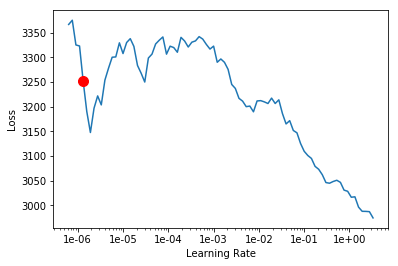

In [21]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [22]:
learn.fit_one_cycle(100, max_lr=0.2, callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='03_dual_fastai_transforms_ATLANTA_best')])

epoch,train_loss,valid_loss,time
0,2242.894043,2599.221436,01:11
1,2074.943115,2349.986084,01:10
2,1933.352905,1892.786499,01:09
3,1958.607666,1967.537720,01:10
4,1977.020386,3803.056396,01:10
5,1964.711060,2453.392578,01:11
6,1915.139282,2421.003906,01:11
7,1950.732788,2648.758057,01:10
8,1927.408447,2014.083374,01:11
9,1924.609009,3957.640137,01:10


Better model found at epoch 0 with valid_loss value: 2599.221435546875.
Better model found at epoch 1 with valid_loss value: 2349.986083984375.
Better model found at epoch 2 with valid_loss value: 1892.7864990234375.
Better model found at epoch 14 with valid_loss value: 1787.77392578125.
Better model found at epoch 20 with valid_loss value: 1777.7330322265625.
Better model found at epoch 80 with valid_loss value: 1689.9422607421875.
Better model found at epoch 84 with valid_loss value: 1663.2003173828125.
Better model found at epoch 91 with valid_loss value: 1648.259765625.
Better model found at epoch 94 with valid_loss value: 1634.4501953125.
Better model found at epoch 95 with valid_loss value: 1591.475830078125.


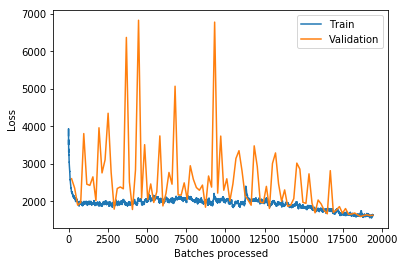

In [23]:
learn.recorder.plot_losses()

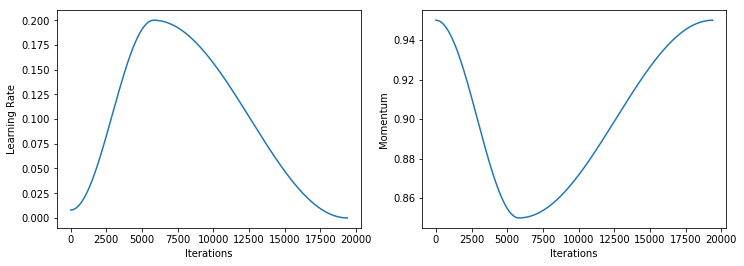

In [24]:
learn.recorder.plot_lr(show_moms=True)

In [25]:
learn.save('03_dual_fastai_transforms_ATLANTA')

## Load the best model

In [26]:
learn.load('03_dual_fastai_transforms_ATLANTA_best')

Learner(data=ImageDataBunch;

Train: LabelList (6232 items)
x: ImageTupleList
ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: .;

Valid: LabelList (1560 items)
x: ImageTupleList
ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: .;

Test: None, model=DualResnet18(
  (GE): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bi

## Evaluate on one example from training set

In [27]:
data.train_ds[0]

(ImageTuple (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),
 FloatItem 1.0)

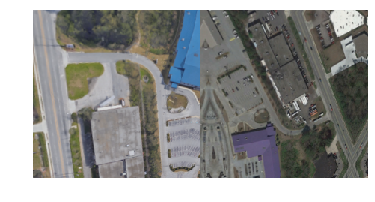

In [28]:
train_example = data.train_ds[0][0]
train_example.to_one().show(figsize=(6,6))

In [29]:
pred = learn.predict(train_example)
pred

(FloatItem 77.97288, tensor(77.9729), tensor(77.9729))

## Evaluate on one example from validation set

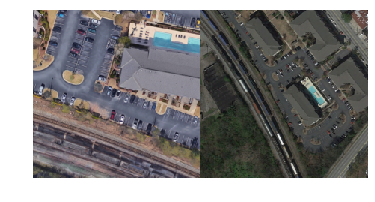

In [30]:
valid_example = data.valid_ds[0][0]
valid_example.to_one().show(figsize=(6,6))

In [31]:
pred = learn.predict(valid_example)
pred[1], learn.data.valid_ds[0][1]

(tensor(33.1768), FloatItem 1.0)

## Evaluate on Training and Validation Set

In [32]:
preds = learn.get_preds(DatasetType.Train)
len(preds), preds[0].shape, preds

(2,
 torch.Size([6208]),
 [tensor([33.2772, 42.5267, 17.8541,  ..., 53.1533, 54.1610, 59.2517]),
  tensor([0., 1., 1.,  ..., 1., 0., 0.])])

In [33]:
v_preds = learn.get_preds(DatasetType.Valid)
len(v_preds), v_preds[0].shape, v_preds

(2,
 torch.Size([1560]),
 [tensor([ 33.1768,  30.0920,  36.1452,  ...,  54.8057,  70.4032, 121.0668]),
  tensor([1., 1., 1.,  ..., 0., 0., 0.])])

In [34]:
def histo(preds, dset):
    matdist, nmatdist = [], []
    for i in range(len(preds[0])):
        if preds[1][i] == 0: nmatdist.append(preds[0][i].numpy())
        if preds[1][i] == 1: matdist. append(preds[0][i].numpy())

    mathist  = plt.hist( matdist, range(int(np.ceil(max( matdist)))), label = 'matching pairs', alpha = 0.7)
    nmathist = plt.hist(nmatdist, range(int(np.ceil(max(nmatdist)))), label = 'non-matching pairs', alpha = 0.7)
    plt.legend(loc='best')
    plt.title(dset + ' data')
    plt.xlabel('Distance between image pairs')
    plt.show()

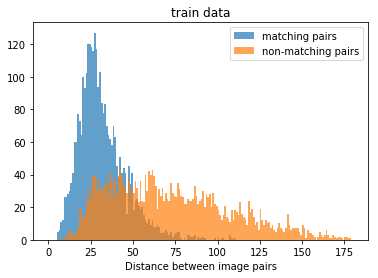

In [35]:
histo(preds, 'train')

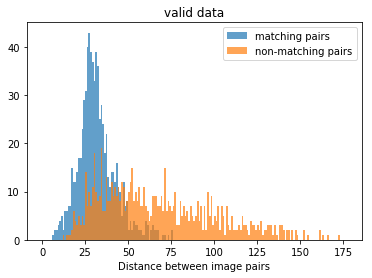

In [36]:
histo(v_preds, 'valid')